In [1]:
from google.colab import drive
drive.mount("/content/drive")
import os
os.chdir("/content/drive/MyDrive/mniscnn")
!pip install dipy healpy

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.8 MB 29.2 MB/s 
     |████████████████████████████████| 23.7 MB 1.2 MB/s 


In [2]:
import sys
import time

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import seaborn as sns
import torch

from mniscnn import (
    compartment_model_simulation,
    isft,
    l_max,
    n_coeffs,
    sft,
    sh,
    SphConv,
)

sns.set_theme()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-33e4c9aa-4577-abb4-5857-abfee61519a6)


In [4]:
# Define acquisition protocol

bvals = torch.tensor(np.loadtxt("data/tensor-valued/lte-pte.bval") / 1e3).float()
bvecs = torch.tensor(np.loadtxt("data/tensor-valued/lte-pte.bvec").T).float()

idx = bvals > 0
bvals = bvals[idx]
bvecs = bvecs[idx]

n_shells = 8
bs = [0.5, 1, 2, 3.5, 5, 0.5, 1, 2]
shell_idx_list = [
    np.arange(12),
    np.arange(12, 24),
    np.arange(24, 44),
    np.arange(44, 64),
    np.arange(64, 94),
    np.arange(94, 106),
    np.arange(106, 118),
    np.arange(118, 138),
]
bvecs_list = [bvecs[idx] for idx in shell_idx_list]
bten_shape_list = [
    "linear",
    "linear",
    "linear",
    "linear",
    "linear",
    "planar",
    "planar",
    "planar",
]

l_max_list = [2, 2, 4, 4, 4, 2, 2, 4]
bvecs_sft_list = []
bvecs_isft_list = []
for i, shell_bvecs in enumerate(bvecs_list):
    thetas = np.arccos(shell_bvecs[:, 2])
    phis = np.arctan2(shell_bvecs[:, 1], shell_bvecs[:, 0]) + np.pi
    bvecs_isft = np.zeros((len(shell_bvecs), n_coeffs))
    for l in range(0, l_max_list[i] + 1, 2):
        for m in range(-l, l + 1):
            bvecs_isft[:, int(0.5 * l * (l + 1) + m)] = sh(l, m, thetas, phis)
    bvecs_sft = np.linalg.pinv(bvecs_isft.T @ bvecs_isft) @ bvecs_isft.T
    bvecs_sft_list.append(torch.tensor(bvecs_sft).float())
    bvecs_isft_list.append(torch.tensor(bvecs_isft).float())

sim_bvecs_isft_list = []
for i, shell_bvecs in enumerate(bvecs_list):
    thetas = np.arccos(shell_bvecs[:, 2])
    phis = np.arctan2(shell_bvecs[:, 1], shell_bvecs[:, 0]) + np.pi
    bvecs_isft = np.zeros((len(shell_bvecs), n_coeffs))
    for l in range(0, l_max + 1, 2):
        for m in range(-l, l + 1):
            bvecs_isft[:, int(0.5 * l * (l + 1) + m)] = sh(l, m, thetas, phis)
    sim_bvecs_isft_list.append(torch.tensor(bvecs_isft).float())

In [5]:
# Define model


class MLPModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(8, 256)
        self.bn1 = torch.nn.BatchNorm1d(256)
        self.fc2 = torch.nn.Linear(256, 256)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.fc3 = torch.nn.Linear(256, 256)
        self.bn3 = torch.nn.BatchNorm1d(256)
        self.fc4 = torch.nn.Linear(256, 4)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.nn.functional.relu(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = torch.nn.functional.relu(x)
        x = self.fc4(x)
        return x


torch.random.manual_seed(123)
model = MLPModel().to(device)

print(f"Number of trainable parameters = {sum(p.numel() for p in model.parameters())}")

Number of trainable parameters = 136452


In [6]:
# Define validation dataset

SNR = 20
n_val = int(1e5)
n_iter = int(1e4)

torch.random.manual_seed(123)
val_ds_1 = torch.rand(n_val) * 3
val_ds_2 = torch.rand(n_val) * val_ds_1.clip(0, 0.5)
val_fs_1 = torch.rand(n_val)
val_fs_2 = torch.rand(n_val) * (1 - val_fs_1)
val_odfs_sh = torch.tensor(np.loadtxt("data/val-subject/odfs_sh.txt")).float()
np.random.seed(123)
val_odfs_sh = val_odfs_sh[np.random.choice(len(val_odfs_sh), n_val)]

val_targets = torch.vstack(
    (
        val_ds_1 / 3,
        val_ds_2 / 3,
        val_fs_1,
        val_fs_2,
    )
).T

val_signals = torch.zeros(n_val, n_shells)

for i in range(0, n_val, int(1e4)):

    idx = torch.arange(i, i + int(1e4))

    batch_ads = torch.vstack(
        (
            val_ds_1[idx],
            val_ds_2[idx],
            val_ds_1[idx]
            * (1 - val_fs_1[idx] - val_fs_2[idx])
            ** (0.5 * val_fs_2[idx] / (val_fs_2[idx] + val_fs_1[idx])),
        )
    ).T
    batch_rds = torch.vstack(
        (
            torch.zeros(len(idx)),
            val_ds_2[idx],
            val_ds_1[idx]
            * (1 - val_fs_1[idx] - val_fs_2[idx])
            ** (
                (0.5 * val_fs_2[idx] + val_fs_1[idx]) / (val_fs_2[idx] + val_fs_1[idx])
            ),
        )
    ).T
    batch_fs = torch.vstack(
        (
            val_fs_1[idx],
            val_fs_2[idx],
            1 - val_fs_1[idx] - val_fs_2[idx],
        )
    ).T
    batch_odfs_sh = val_odfs_sh[idx]

    for j, b in enumerate(bs):
        signals = compartment_model_simulation(
            b,
            sim_bvecs_isft_list[j],
            batch_ads,
            batch_rds,
            batch_fs,
            batch_odfs_sh,
            bten_shape_list[j],
            device,
        ).cpu()
        signals = torch.abs(
            signals
            + torch.normal(
                mean=torch.zeros(signals.size()),
                std=torch.ones(signals.size()) / SNR,
            )
            + 1j
            * torch.normal(
                mean=torch.zeros(signals.size()),
                std=torch.ones(signals.size()) / SNR,
            )
        )
        val_signals[idx, j] = torch.mean(signals, dim=1).squeeze()

val_loss = 0.013521579094231129
training took 0.87 h


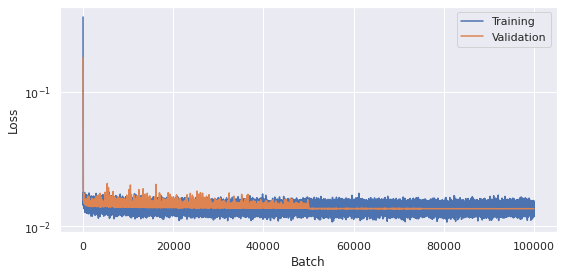

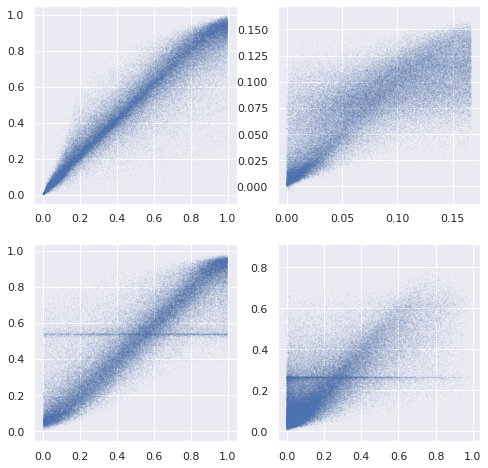

In [7]:
# Train

batch_size = int(1e3)
n_batches = int(1e5)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

train_odfs_sh = torch.tensor(np.loadtxt("data/train-subject/odfs_sh.txt")).float()
Rs = torch.tensor(
    np.concatenate(
        (
            np.eye(45)[np.newaxis],
            np.load("data/train-subject/Rs.npy").reshape(-1, n_coeffs, n_coeffs),
        ),
        axis=0,
    )
).float()

train_losses = []
val_losses = []

start_time = time.time()

for batch in range(n_batches):

    if batch == int(5e4) or batch == int(7.5e4):
        scheduler.step()

    torch.random.manual_seed(batch)
    random_ds_1 = torch.rand(batch_size) * 3
    random_ds_2 = torch.rand(batch_size) * random_ds_1.clip(0, 0.5)
    random_fs_1 = torch.rand(batch_size)
    random_fs_2 = torch.rand(batch_size) * (1 - random_fs_1)

    batch_targets = torch.vstack(
        (
            random_ds_1 / 3,
            random_ds_2 / 3,
            random_fs_1,
            random_fs_2,
        )
    ).T

    np.random.seed(batch)
    batch_odfs_sh = train_odfs_sh[np.random.choice(len(train_odfs_sh), batch_size)]
    batch_Rs = Rs[np.random.choice(len(Rs), batch_size)]
    batch_odfs_sh = (batch_Rs @ batch_odfs_sh.unsqueeze(-1)).squeeze(-1)

    batch_ads = torch.vstack(
        (
            random_ds_1,
            random_ds_2,
            random_ds_1
            * (1 - random_fs_1 - random_fs_2)
            ** (0.5 * random_fs_2 / (random_fs_2 + random_fs_1)),
        )
    ).T
    batch_rds = torch.vstack(
        (
            torch.zeros(batch_size),
            random_ds_2,
            random_ds_1
            * (1 - random_fs_1 - random_fs_2)
            ** ((0.5 * random_fs_2 + random_fs_1) / (random_fs_2 + random_fs_1)),
        )
    ).T
    batch_fs = torch.vstack(
        (
            random_fs_1,
            random_fs_2,
            1 - random_fs_1 - random_fs_2,
        )
    ).T

    pa_signals = torch.zeros(batch_size, n_shells)
    for j, b in enumerate(bs):
        signals = compartment_model_simulation(
            b,
            sim_bvecs_isft_list[j],
            batch_ads,
            batch_rds,
            batch_fs,
            batch_odfs_sh,
            bten_shape_list[j],
            device,
        ).cpu()
        signals = torch.abs(
            signals
            + torch.normal(
                mean=torch.zeros(signals.size()),
                std=torch.ones(signals.size()) / SNR,
            )
            + 1j
            * torch.normal(
                mean=torch.zeros(signals.size()),
                std=torch.ones(signals.size()) / SNR,
            )
        )
        pa_signals[:, j] = torch.mean(signals, dim=1).squeeze()

    y = model(pa_signals.to(device))
    loss = loss_fn(y, batch_targets.to(device))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_losses.append(loss.item())

    if batch % 10 == 0 or batch == n_batches - 1:
        model.eval()
        with torch.no_grad():
            val_preds = torch.zeros(val_targets.size()).to(device)
            for i in range(0, n_val, n_iter):
                idx = torch.arange(i, i + n_iter)
                val_preds[idx] = model(val_signals[idx].to(device))
            val_losses.append(loss_fn(val_preds, val_targets.to(device)).item())
        model.train()

    sys.stdout.write(
        f"\rbatch = {batch + 1}, train loss = {train_losses[-1]}, val loss = {val_losses[-1]}"
    )
    sys.stdout.flush()

sys.stdout.write(f"\rval_loss = {val_losses[-1]}\n")
sys.stdout.flush()

print(f"training took {np.round((time.time() - start_time) / 60 ** 2, 2)} h")

fig = plt.figure(figsize=(8, 4))
plt.plot(np.linspace(1, n_batches, n_batches), train_losses)
plt.plot(np.linspace(1, n_batches, len(val_losses)), val_losses)
plt.yscale("log")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    for j in range(2):
        k = 2 * i + j
        sc = ax[i, j].scatter(val_targets[:, k], val_preds[:, k].cpu(), s=1, alpha=0.1)
        sc.set_edgecolor("none")
plt.show()

torch.save(model.state_dict(), "mlp_neural_soma_model_weights.pt")
np.savetxt("mlp_neural_soma_train_losses.txt", train_losses)
np.savetxt("mlp_neural_soma_val_losses.txt", val_losses)